In [10]:
%matplotlib inline


Reinforcement Learning (DQN) on MountainCar_V0 Environment
=====================================

##### Please view this page live on GitHub at: https://gist.github.com/tomereldor/255576a756c27fec4c046a8550ea9562 
This implementation is based on Pytorch's official tutorial for reinforcement learning DQN algorithm, with the Cartpole environment. It is here changed to work with the Mountain Car environment.

The original implementation implements the DQN algorithm with **fixed Q targets**, on the basis of image recognition from the screen.
Here I present the following versions:
1. Original **Fixed Q targets**, vision based DQN
2. **Double DQN**, vision based model
3. **Modified Reward to less sparse** – Built in a flag that modifies the reward to also reflect _in each step_ the distance from the goal, and reward the agent for any progress towards the goal, while still having a larger ("jackpot") reward at the goal. This allows for much faster learning since otherwise the agent needed to try random actions thousands of times at least before randomly reaching the goal.
4. **DQN_Light** – non-vision based lighter version, which runs much faster, with the modified reward.



**Task**
The agent's goal is to get the car from the valley up to the goal post on the right. However, the engine of the car is not strong enough to climb that hill. It needs to learn eventually to use the back hill in order to get momentum and, like a swing, eventually gain enough momentum + engine power to reach the goal.
Official leaderboard with various algorithms and visualizations at the
`Gym website <https://gym.openai.com/envs/MountainCar-v0/>`__.


As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. 

**Environment Observation**: The environment observation consists of position and velocity of the car alone.

**Actions**: The agent has to decide between three actions: moving the cart left, right, or do nothing.

**Reward**: -1 for each time step, until the goal position of 0.5 is reached. As with MountainCarContinuous v0, there is no penalty for climbing the left hill, which upon reached acts as a wall.

**Starting State**: Random position from -0.6 to -0.4 with no velocity.

**Episode Ends**: The episode ends when you reach 0.5 position, or if 200 iterations are reached.

While in the original tutorial the state was calculated as the `difference between the current screen patch and the previous one` - that was in order to allow the agent to take the velocity of the pole into account from one image. However, here we observe the velocity directly; so we don't need the difference, but can take directly the new state.


**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




## Set Up

In [11]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from time import time 

import ipympl
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import pandas as pd
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from datetime import datetime
import glob, os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# Make the gym environment
env = gym.make('MountainCar-v0').unwrapped

# set random seeds
np.random.seed(100)
torch.manual_seed(100)
env.seed(100)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.

**A future extension for this could be priorities experience replay. That would be implemented by saving the resulted penalty with each experience stored in memory (below in the `push` function) and then modifying the `sample` function to sample considering the "badness" of the experience**.

However, there are more subtleties to this. In PER we ensure not only the same experiences are sampled all the time by applying stochastic normalization with a constant alpha. When performing gradient updates we weight experiences by their inverse priority (sampling probability) to reduce their impact on the weight update, this becomes more important when we get towards convergence. While these techniques seem like they would reduce the impact of prioritization slightly they improve and speed-up learning by ensuring difficult cases are seen appropriately often but don't overwhelm the model.

In [12]:
# named tuple of transition and arg-names, for later inserting as memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    ''' 
    Experiences storage object which saves past experiences
    and allows us to easily sample from them, 
    while capping the maximum capacity and observing the memory size.
    
    Arguments: 
        – Capacity: maximum number of experiences to store
    Usage:
        ReplayMemory.push() : save an experience into the object
        ReplayMemory.sample() sample an experience randomly
        len(ReplayMemory) – returns length of memory (amount of experiences stored)
    '''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """ Saves a transition. """
        # if we haven't reached maximum capacity, add another memory. 
        # otherwise, overwride an existing memory
        if len(self.memory) < self.capacity:
            self.memory.append(None) # add another memory slot
        # save the last transition in the current [i] position in memory
        self.memory[self.position] = Transition(*args) 
        # advance [i] position slot (or restart if reached capacity)
        self.position = (self.position + 1) % self.capacity 

    def sample(self, batch_size):
        """ Samples an experience from memory randomly"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """ Returns length of memory """
        return len(self.memory)


# DQN algorithm

**The following paragraph is from the original PyTorch Tutorial, and still relevant to this implementation.**

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. 


We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}


## DQN-1: Deep Convolutional Q-Network

Our model will be a convolutional neural network that takes in the
difference between the current and previous screen patches as its observation. 
The network is trying to predict the *quality* of
taking each action given the current input.

**This network structure will be used for both the policy network and the target networks, used separately to calculate the Q values and choose from them in Dual DQN**. 

This would be approximating the Qs of state and action pairs at time t:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \big[r_t + \gamma \max\limits_{a} Q(s_{t+1},a_{t+1}) - Q(s_t,a_t)\big]  \tag{Q-Learning}$$

**The original implementation's inputs were Screen Captures. This is it below.**

In [13]:
# Create the Neural Network Architecture for DQN

class DQN(nn.Module):
    ''' Vision based DQN: learn based on screen difference inputs'''

    def __init__(self, net_type="fixed"):
        ''' Define DQN Network Class Architecture'''
        # store type of network upon creation for later reference
        self.net_type = net_type 
        super(DQN, self).__init__()
        
        # L1: 2D convolution, halving the size (stride=2), + batch norm
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        # L2: 2D convolution, halving the size (stride=2), + batch norm
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        # L3: 2D convolution, halving the size (stride=2), + batch norm
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        # L4: Last Fully Connected Linear layer defines action to take (left/right)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        '''Forward propagate x input through the nextwork'''
        x = F.relu(self.bn1(self.conv1(x))) # x after L1
        x = F.relu(self.bn2(self.conv2(x))) # x after L2
        x = F.relu(self.bn3(self.conv3(x))) # x after L3
        return self.head(x.view(x.size(0), -1)) # x after L4
    

## DQN-2: "Light"  Neural Network for sparse input format
##### direct velocity and position information

Alternatively, below I add another option of how simple would the architechture be if we would use the version with direct information as inputs.

In the MountainCar Problem: we have only a 1D input of length 2 (x_position, velocity).
The action space we want to map to is one of 3 actions (left, nothing, right)
 Therefore we just need a flexible network to learn mapping between those inputs (size [1,2]) to value functions of the 3 possible outputs (output size: [1,3])

In [14]:
class DQN_light(nn.Module):
    ''' 
    Neural Network choosing action based on direct state value observations
    Input: 1D of length 2 (x_position, velocity) 
    Output: 1D of length 3 (left, nothing, right)
    '''    
    def __init__(self, hidden = 64):
        ''' Define DQN Network Class Architecture'''
        self.net_type = "light"
        super(DQN_light, self).__init__()
        
        # input is the size of the direct observation the environment gives us (1D array of 2x1)
        self.input_size = env.observation_space.shape[0]
        # output size is the Q for each possible action
        self.output_size = env.action_space.n
        # manually define number of hidden nodes 
        self.hidden_size = hidden 
        # 2 Fully connected layers with one hidden layer:
        self.fc1 = nn.Linear(self.input_size, self.hidden_size, bias=False) # L1, Linear/fully connected
        self.fc2 = nn.Linear(self.hidden_size, self.output_size, bias=False) # L2, Linear/fully connected
    
    def forward(self, x):    
        '''Forward propagate x input through the nextwork'''
        # propate x via fc1 then fc2 and return the neural net's ouptut
        out_ff_net = torch.nn.Sequential(
            self.fc1,
            self.fc2,
        )
        return out_ff_net(x)
    
def weights_init(m):
    ''' initializes weights to all NN weight needed layers (linear FC layers here)'''
    classname = m.__class__.__name__
    # find all layers with "Linear" in their name (all our NN layers)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

## Screen Input extraction

The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




In [17]:
# import torchvision.transforms as T
# Resize image and turn into tensor
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])
screen_width = 600

def get_cart_location():
    ''' Get the position of the cart (car/cart...)'''
    world_width = env.max_position * 2 #modified to fit env
    # if env=="light":
    #    world_width = env.max_position
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    ''' Read the screen from input'''
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    
    # Strip off the top and bottom of the screen, slice based on cart location
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
# uncomment the line below to see picture
# plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
# plt.title('Example extracted screen')
# plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Training
----------------

## Hyperparameters and Action Selection
This cell instantiates our model and its optimizer, and the action selection function.

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
  
Meaning, we start with mostly exploring (high epsilon = high probability of random action exploration), and with time the espilon decays, which makes as "exploit" more – take the maximal valued function from our Q estimates.

##### Here we initialize the policy and target networks. 


In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# For Fixed Targets DQNs:
policy_net = DQN().to(device)
target_net = DQN().to(device)

# ALTERNATIVELY; if you wanted the small and efficient network with 
## direct input information rather than vision oriented, 
# comment the above 2 lines and uncomment these below

# policy_net = DQN_light().to(device)
# policy_net.apply(weights_init)
# target_net = DQN_light().to(device)

# Copy parameters from PolicyNet to TargetNet
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0

def select_action(state, net_type=0):
    ''' function which selects best action: left/right based on Q network state values'''
    global steps_done    
    
    # Threshold defines with which probability should we move left/right
    # This is an epsilon-greedy exploration/exploitation strategy; where we exploit 
    # our Q knowledge but at each point we randomly explore with probability epsilon.
    # To prioritize exploration at first but later on exploitation, 
    # we start with a large epsilon (probability of exploring random action) 
    # and decay it the epsilon threshold with time (steps)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    # random draw for epsilon-greedy method - decide to randomly explore rather then exploit
    sample = random.random()
    
    # Exploitation: If random>threshold, exploit our network
    if sample > eps_threshold:        
        # for light DQN:
        if policy_net.net_type=="light":

            # exploit: compute Q values for each action
            Q = policy_net(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
            # with torch.no_grad(): #debug
            _, action = torch.max(Q, -1) # choose action with max Q value
            print("light DQN action = ", action.item()) #debug
        
        # for full DQN (either fixed targets or dual:)
        else: 
            with torch.no_grad():
                action = policy_net(state).max(1)[1].view(1, 1)
                # print("full DQN action = ", action.item()) #debug
    
    # Exploration: choose a random action between 0,1,2 (is random sample is within espilon)
    else:        
        action = torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long) 
    return action

### Training: Optimization

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.


To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy.


In [23]:
def optimize_model(method="fixed"):
    '''
    Model Optimizer and Learning
    Input: method
    if Method=="fixed":
        This will train a Fixed-Target DQN.
    If method=="double":
        This will instead train a double DQN.
    
    '''
    
    # memory must be at least as large as BATCH_SIZE
    if len(memory) < BATCH_SIZE:
        #if incorrect batch size, stop.
        #print("Memory of memory replay must be at least Batch Size. It's currently smaller")
        return
    
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))
    
    ### Build the computation graph for Q-learning ###
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    next_state_values = Variable(torch.zeros(BATCH_SIZE)) # this would be for the DQN_Small

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)#TODO: #.cpu()

    # Compute V(s_{t+1}) for all next states.
    # Double DQN is a different way to calculate the Q Values for the next state:
    # using a different network (target network) for that, rather than the same.
    # here we implement this:
    next_state_values = torch.zeros(BATCH_SIZE, device=device) 
    
    ### (1) For a Fixed-Q-Target DQN:
    if method=="fixed":
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    ### (2) For Double DQN instead: ###
    elif method=="double":
        _, best_next_action = policy_net(non_final_next_state).max(1, keep_dim=True) #location of max val in tensor
        next_state_values[non_final_mask] = target_net(non_final_next_states)[:, best_next_action]

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Clamps the gradients to (-1,1) in-place 
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    
    # Update variables from back-prop
    optimizer.step()
    
    return loss # return loss for documentation

### Performance Evaluation Plotting Functions

In [21]:
#### Performance Evaluation: Original Plotting durations function
    
# Performance Results Plotting function
def plot_history(array, name):
    "quickly plot a history of performance indicators"
    plt.figure(2, figsize=[10,5])
    p = pd.Series(array)
    plt.plot(p, alpha=0.8)
    plt.xlabel("Episode")
    plt.ylabel(name)
    plt.title(name + ' History in Training...')
    return plt.show()

def plot_final_position_with_ma(end_position_history):
    ## plotting the final position at the end of each episode
    plt.figure(2, figsize=[10,5])
    p = pd.Series(end_position_history)
    ma = p.rolling(10).mean()
    plt.plot(p, alpha=0.8)
    plt.plot(ma)
    plt.xlabel('Episode')
    plt.ylabel('Position')
    plt.title('Car Final Position')
    plt.savefig('Final Position - Modified.png')
    plt.show()

# Training 1: Vision Based DQN – Fixed Targets, Dual DQN, Sparse and Timely Rewards

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

#### Notice that now we have flags that allow us to modify the network between Fixed Targets, Dual DQN, Sparse and Timely Rewards.

### 1. Fixed Q Targets
This is the original version here. Fixed Q targets uses a separate network with a fixed parameter for estimating the TD target. The separate network is basically a copy of the first network, but its parameters are freezed and only update every N (say, a 1000) iterations. 
This method is because when we use the same network and same parameters (weights) for estimating the target and the Q value, there is a big correlation between the TD target and the parameters we are changing.
So, as we update our weights, also are targets are moving. Think of this as like chasing a moving target. This may cause wild oscilations, since as we move towards the target, the target changes, and may change directions as well. This of it as chasing a chicken. (This wonderful analogy from this explanation here: https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682)

### 2. Double (/Dual) DQN
Double DQN helps us reduce the overestimation of q values and, as a consequence, helps us train faster and have more stable learning.
This is because, especially in the beginning or depending on the states we explored, we don't know everything yet, and thus our estimation owuld be biased. We know that the accuracy of q values depends on what action we tried and what neighboring states we explored. If non-optimal actions are regularly evaluated more highly, we will not exploit the best actions but think that we are, and thus never actually reach the goal.
Doulbe DQN solves this by computing the Q target by two networks to decouple the action selection from the target Q value generation. 

It shows like this:
1. The policy network selects the best action to take for the next state (the action with the highest Q value).
2. The target network calculates the target Q value of taking that (already selected) action at the next state.

### 3. Sparse and Timely Rewards
The learning took too long, and I understood that it wasn't learning anything good because it was never recieving the reward! (or taking thousands of games to randomdly reach that goal). That is the problem with sparse rewards: the default reward in this envrionemnt is constant until the car reaches the goal where it changes to +1. Therefore, the agent doesn't know where to go most of the time. 
Hence, I created an option to modify the reward to be more timely (as we know, from the science of learning, that timely and action-based rewards teach the best!). That reward takes adds the **position of the car**, since it starts around 0 and needs to reach 0.5 (and the screen cuts off at 0.6, so it really just needs to aspire to the positive side of the X axis). It still has the original reward built in, such that when it reaches the goal it gets a "jackpot".


##### Training Loop for vision based DQN

In [25]:
##### Training Loop for vision based DQN

def train_DQN(num_episodes = 5, method = "fixed", max_steps=200, adjust_reward=False):
    ''' Training loop'''
    start_time = time()
    loss_history = []
    reward_history = []
    durations_history = []
    end_position_history = []
    successes = 0
    
    for i_episode in range(num_episodes):
        # show env play every 100 episodes
        if i_episode % 100 == 0: env.render()
        
        # Initialize the environment and state
        env.reset()
        episode_loss = 0    # initialize loss counter for entire episode
        episode_reward = 0  # initialize reward counter for entire episode

        # Build state of current as difference of two frames
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen

        for t in count():
            # Select and perform an action 
            # select action with dacying-epsilon-greedy strategy
            action = select_action(state)
            # perform action and save output of next step
            observation, reward, done, _ = env.step(action.item())
            
            # MODIFIED REWARD 
            # The original reward only changes when agent reaches the goal; 
            # but that takes forever because of the steepness of the hill (sparse rewards).
            # we can make things more obvious and faster for learning if we give some more
            # information: reward for getting closer to the goal
            # observation[0] is position; we want it to go more right to the position of 0.5
            # ; approach a reward of 1 as it approaches position 0.5
            reward = 0.5*reward + observation[0]   
            reward = torch.tensor([reward], device=device) # save reward
            
            # Observe new state
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                # next state is the difference between screens, 
                # as a proxy of movemnet (which is a proxy for position and velocity)
                next_state = current_screen - last_screen
            else:
                # if we're done, no next state
                next_state = None

            # Store the transition in memory
            # for later pulling for memory replay
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            # HERE "method" SPECIFIES IF YOU WANT FIXED OR DUAL DQNs
            loss = optimize_model(method)
            
            # Log performance metrics – add to sum up as episode counter
            if loss: episode_loss += loss.item()
            episode_reward += reward.item()
            print("{}-{}: action = {}, reward = {}, loss={}, done?{}".format(i_episode, t, action.item(), reward.item(), loss, done))
            
            # if game over (reached goal or reach max timesteps), record it
            if done or (t > max_steps):
                episode_durations.append(t + 1)
                plot_durations()
                break
        
        # Print Episode details
        print("===Episode {}. Duration={}. Success={}. Loss={}. Reward={}===".format(i_episode, t+1, done, episode_loss, episode_reward))
        
        # RECORD HISTORY (#modified for performance evaluation)
        durations_history.append(t+1)
        reward_history.append(reward.item())
        loss_history.append(episode_loss)
        
        # Update the target network
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())


    end_time = time()
    env.render()
    env.close()
    plt.ioff()
    print('{} – Completed all {} episodes in {} minutes'.format(end_time, num_episodes, (end_time-start_time)/60))
    #plt.show()


### Running Vision Based DQNs

### 1.1 Fixed Targets DQN

In [ ]:
# For Fixed Targets DQNs:
policy_net = DQN().to(device)
target_net = DQN().to(device)
# Copy parameters from PolicyNet to TargetNet
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

print(policy_net.net_type)
# TRAIN THE MODEL!
train_DQN(num_episodes=300, method="fixed", max_steps=300)

In [ ]:
plot_history(loss_history, "Loss")
plot_history(durations_history, "Episode Duration")
plot_history(reward_history, "Reward given")

### 1.2 Double (Dual) DQN

In [ ]:
# TRAIN THE MODEL!
train_DQN(num_episodes=100, method="dual", max_steps=300)

In [ ]:
plot_history(loss_history, "Loss")
plot_history(durations_history, "Episode Duration")
plot_history(reward_history, "Reward given")

*** these took too long and didn't finish, then didn't work on google colab because of vision engine needed, then here completed a small number of espisodes. but somehow histories weren't saved_

# Training 2: Light DQN with timely rewards

This version and its policy evaluation is built upon: https://medium.com/@ts1829/solving-mountain-car-with-q-learning-b77bf71b1de2


In [ ]:
### Alternative training version for Small / Sparse DQN version

def train_lightDQN(num_episodes = 100, max_steps=200):
    ''' Training loop'''
    start_time = time()
    loss_history = []
    reward_history = []
    durations_history = []
    end_position_history = []
    successes_history = []
    print("{} – Starting training for {} episodes.".format(start_time, num_episodes))
    
    for i_episode in range(num_episodes):
         # show env play every 100 episodes
        if i_episode % 100 == 0: env.render() 
        
        # Initialize the environment and state
        env.reset()
        episode_loss = 0    # initialize loss counter for entire episode
        episode_reward = 0  # initialize reward counter for entire episode

        # Build state of current as difference of two frames
        state = env.state

        for t in count():
            # Select and perform an action 
            action = select_action(state)
            # perform the selected action and observe reward and effect on environment
            state2 , reward, done, _ = env.step(action.item())
            
            # next state is an array ("box") describing [position, velocity]
            [position, velocity] = state2
            
            # MODIFY REWARD:
            # Since the environment's reward is binary (1 for success at 0.5 and 0 otherwise),
            # the agent has no information of how close is it and will take a long while to 
            # figure out where to go and what to do.
            # Since the goal is to reach position (0.5), here I will change the reward to reflect that:
            # reward is -1 until reaching goal, so adding 0.5 will be 0 until reaching goal
            # so until reaching goal, reward = position; and reward==2 when reaching goal
            # reward = torch.tensor([reward], device=device)            
            reward = 0.5*reward + 0.5 + position 

            # Observe new state
            
            # last_screen = current_screen
            # current_screen = get_screen()
            
            
            # Update state, unless game is over (then finish)
            if not done:
                next_state = state2
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the target network)
            # update model parameter using information from new state
            loss = optimize_model()
            
            ## Done with step, now log and finish or repeat next step
            
            # Log performance metrics – add to sum up as episode counter
            if loss: episode_loss += loss.item()
            episode_reward += reward
            success = done 
            
            # if we succeeded / game over:
            if done or (t > max_steps):
                episode_durations.append(t + 1)
                plot_durations()
                break
        
        # Print Episode details
        #print("Episode {} done. Success={}. End_pos={}. Duration={}. Loss={}. Reward={}".format( (i_episode, success, state2, t+1, episode_loss, episode_reward)))
        print("===Episode {}. Duration={}.  End_pos={}. Success={}. Loss={}. Reward={}===".format(i_episode, t+1, state2[0], done, episode_loss, episode_reward))

        # RECORD HISTORY (#modified for performance evaluation)
        durations_history.append(t+1)
        reward_history.append(reward)
        loss_history.append(episode_loss)
        end_position_history.append(state2[0])
        successes_history.append(done)
        # Update the target network
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
    end_time = time()
    env.close()
    plt.ioff()
    print('Completed all {} episodes, {} successfully - {}%'.format(num_episodes, np.sum(successes_history), np.sum(successes_history)/num_episodes))

In [5]:
env.reset()
# Prepare networks
policy_net = DQN_light().to(device)
policy_net.apply(weights_init)
target_net = DQN_light().to(device)
# Copy parameters from PolicyNet to TargetNet
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Train networks
train_lightDQN(num_episodes=1000, max_steps=200)

100%|██████████| 1000/1000 [02:37<00:00, 15.94it/s]

Completed all 1000 episodes, 591 successfully - 59.1%


### Light DQN Performance 

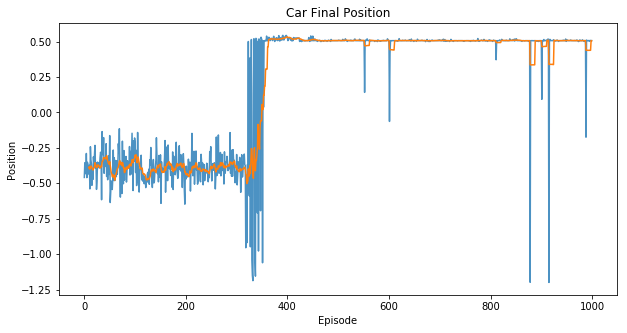

In [6]:
plot_final_position_with_ma(end_position_history)

**After ~320 training episodes, our agent learned to reach the goal and starts reaching the goal often, but still exploring with some unsuccessful episodes interlaced. Before 400 episodes the agent moves to complete successfully almost all episodes, but still with some occasional unsuccessful explorations.**

<iframe width="900" position="800" frameborder="0" scrolling="no" src="//plot.ly/~ts1829/22.embed"></iframe>